# DQN_v4: 芝加哥房地产价格估算的深度Q网络

本Notebook将DQN_v2的架构迁移至新的芝加哥房地产数据集。整体流程与DQN_v2保持一致，包括数据预处理、线性回归基准模型、强化学习环境设计、PyTorch下的DQN模型定义、训练与评估。目标是训练一个DQN智能体，在基准估价的基础上学习价格调整策略，提升房价预测的准确性。本项目所有价格均以“美元”为单位。

## Part 1: 数据预处理
首先加载芝加哥房地产数据集（real_estate_data_chicago.csv），并对数据进行清洗与特征工程。本次实验中，仅使用数值型特征，不考虑文本描述与类别型特征（text特征将在后续版本DQN_v5中引入）。我们选用以下9个输入特征：

- year_built：建筑年份

- beds：卧室数量

- baths：卫生间总数（full + half）

- baths_full：全卫数量

- baths_half：半卫数量

- garage：车库数量

- lot_sqft：土地面积（平方英尺）

- sqft：房屋室内面积（平方英尺）

- stories：楼层数

预测目标有两个：

1. 总价（listPrice，单位美元）

2. 单价（price，按listPrice / sqft计算，单位美元/平方英尺）

预处理步骤：

1. 加载数据并计算price（listPrice / sqft）。

2. 删除listPrice或sqft缺失的数据。

3. 对于year_built、lot_sqft、stories等特征用中位数填充缺失值。

4. 对baths_half与garage缺失值用0填充（代表无半卫或车库）。

5. 训练集与测试集按80/20划分，确保随机种子固定（42）。

6. 准备好特征矩阵X与目标变量y。

In [20]:
import pandas as pd
import numpy as np
import random

random.seed(42)
np.random.seed(42)

df = pd.read_csv('real_estate_data_chicago.csv')
df['price'] = df['listPrice'] / df['sqft']
df = df.dropna(subset=['listPrice', 'sqft'])

if 'status' in df.columns:
    df = df[df['status'] != 'ready_to_build']

df['year_built'] = df['year_built'].fillna(df['year_built'].median())
df['baths'] = df['baths'].fillna(df['baths_full'] + 0.5 * df['baths_half'].fillna(0))
df['baths_full'] = df['baths_full'].fillna(df['baths'].round().fillna(0))
df['baths_half'] = df['baths_half'].fillna(0)
df['garage'] = df['garage'].fillna(0)
df['lot_sqft'] = df['lot_sqft'].fillna(df['lot_sqft'].median())
df['stories'] = df['stories'].fillna(df['stories'].median())

features = ['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage', 'lot_sqft', 'sqft', 'stories']
target_total = 'listPrice'
target_price = 'price'

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train_num = train_df[features].values
X_test_num = test_df[features].values
y_train_total = train_df[target_total].values
y_test_total = test_df[target_total].values
y_train_price = train_df[target_price].values
y_test_price = test_df[target_price].values

print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


训练集大小: 1154, 测试集大小: 289


## Part 2: 线性回归基准模型

在进入强化学习前，先训练一个简单的线性回归模型，用于预测每平方英尺价格（price）。线性模型的输出将作为DQN的初始估价（base_price）。

具体步骤：

1. 用训练集特征X_train与目标y_train_price（单价）训练线性回归模型。

2. 预测训练集与测试集的单价，并乘以sqft得到总价预测（base_price）。

3. 计算基准模型在测试集上的MAE与RMSE。

4. 打印部分测试样本的实际价格与基准预测价格。



In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline 仅用数值特征，不使用文本特征
linreg = LinearRegression()
linreg.fit(X_train_num, y_train_price)

pred_train_price = linreg.predict(X_train_num)
pred_test_price = linreg.predict(X_test_num)

# 还原为总价（平方英尺 * 单位面积价格）
base_price_train = pred_train_price * train_df['sqft'].values
base_price_test = pred_test_price * test_df['sqft'].values

# Baseline Evaluation
baseline_mae = mean_absolute_error(y_test_total, base_price_test)
baseline_rmse = mean_squared_error(y_test_total, base_price_test, squared=False)

print(f"Baseline Model MAE: ${baseline_mae:,.0f}")
print(f"Baseline Model RMSE: ${baseline_rmse:,.0f}")


Baseline Model MAE: $230,364
Baseline Model RMSE: $718,476


## Part 3: 强化学习环境设计

环境仿真智能体估价的过程，核心逻辑与DQN_v2一致：

- 状态（state）：房产的数值型特征向量。

- 动作（action）：7个离散调整幅度（±20%、±10%、±5%、0%）。

- 初始估价：基于线性回归预测的base_price。

- 奖励（reward）：调整后估价与实际价格的绝对误差（负数），若采取±20%的大动作则附加5万美元惩罚。

- 每个episode仅有一步动作，即智能体观察房产特征后立刻给出调整百分比，之后episode结束。



In [13]:
class HousingPricingEnv:
    def __init__(self, states, true_prices, base_prices, adjustments):
        self.states = states
        self.true_prices = true_prices
        self.base_prices = base_prices
        self.actions = adjustments
        self.n = len(states)

    def reset(self):
        self.idx = np.random.randint(0, self.n)
        self.current_state = self.states[self.idx]
        self.true_price = self.true_prices[self.idx]
        self.current_guess = self.base_prices[self.idx]
        return self.current_state

    def step(self, action_idx):
        adjustment = self.actions[action_idx]
        self.current_guess *= (1 + adjustment)
        #diff = abs(self.current_guess - self.true_price)
        #reward = -diff
        
        diff = abs(self.current_guess - self.true_price)
        reward = -diff / 10000  # Reward归一化为“万元单位”
        
        if abs(adjustment) > 0.1:
            reward -= 5.0
        done = True
        return self.current_state, reward, done

adjustments = [-0.20, -0.10, -0.05, 0.0, 0.05, 0.10, 0.20]
env = HousingPricingEnv(X_train, y_train_total, base_price_train, adjustments)


## Part 4: DQN模型定义
DQN网络结构：

- 输入层：9个特征。

- 隐藏层：第一层128节点，第二层64节点，激活函数ReLU。

- 输出层：7个动作的Q值（线性输出）。

- 保持policy_net与target_net架构一致，定期同步参数。

训练配置：

- 经验回放池（Replay Buffer）。

- 损失函数：均方误差（MSE）。

- 优化器：Adam。

- ε-贪婪策略用于平衡探索与利用，ε从1.0指数衰减到0.01。

- target_net每隔固定轮次（如10轮）更新。

- 训练迭代1000轮。

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from collections import deque

class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

state_dim = X_train.shape[1]
action_dim = len(adjustments)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQNNet(state_dim, action_dim).to(device)
target_net = DQNNet(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer(50000)

num_episodes = 1000
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
target_update_freq = 10

epsilon = epsilon_start
steps_done = 0

episode_losses = []
episode_rewards = []


## Part 5: DQN训练过程

每轮训练步骤：

1. 环境随机抽取一个房产作为state。

2. 按ε-贪婪策略选择一个动作（百分比调整）。

3. 环境返回调整后估价与reward（负误差）。

4. 将(state, action, reward, next_state, done)存入回放池。

5. 从回放池中采样批量数据进行DQN更新。

6. 每隔固定轮次更新target_net。

7. 记录每轮的reward与loss，并定期输出训练进度。

In [15]:
for i_episode in range(1, num_episodes + 1):
    state = env.reset()
    state_tensor = torch.FloatTensor(state).to(device)
    total_reward = 0.0
    total_loss = 0.0
    updates = 0

    if random.random() < epsilon:
        action = random.randrange(action_dim)
    else:
        with torch.no_grad():
            q_values = policy_net(state_tensor.unsqueeze(0))
        action = q_values.argmax(dim=1).item()

    next_state, reward, done = env.step(action)
    total_reward += reward
    memory.push(state, action, reward, next_state, done)

    steps_done += 1
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * steps_done / epsilon_decay)

    if len(memory) >= batch_size:
        transitions = memory.sample(batch_size)
        batch_state = torch.FloatTensor([t[0] for t in transitions]).to(device)
        batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
        batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
        batch_next_state = torch.FloatTensor([t[3] for t in transitions]).to(device)
        batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)

        q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        next_q_values = target_net(batch_next_state).max(1)[0]
        target_q = batch_reward + gamma * next_q_values * (1 - batch_done)
        loss = nn.MSELoss()(q_values, target_q.detach())
        optimizer.zero_grad()
        #loss.backward()
        #ptimizer.step()
        #修改后：
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        updates += 1

    episode_losses.append(total_loss / updates if updates > 0 else 0.0)
    episode_rewards.append(total_reward)

    if i_episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if i_episode % 100 == 0:
        avg_reward = sum(episode_rewards[-100:]) / 100
        avg_loss = sum(episode_losses[-100:]) / 100
        print(f"Episode {i_episode}/{num_episodes} - Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")


Episode 100/1000 - Avg Reward: -29.39, Epsilon: 0.82
Episode 200/1000 - Avg Reward: -35.22, Epsilon: 0.67
Episode 300/1000 - Avg Reward: -30.27, Epsilon: 0.55
Episode 400/1000 - Avg Reward: -33.59, Epsilon: 0.45
Episode 500/1000 - Avg Reward: -27.61, Epsilon: 0.37
Episode 600/1000 - Avg Reward: -17.95, Epsilon: 0.31
Episode 700/1000 - Avg Reward: -33.35, Epsilon: 0.25
Episode 800/1000 - Avg Reward: -24.58, Epsilon: 0.21
Episode 900/1000 - Avg Reward: -24.26, Epsilon: 0.17
Episode 1000/1000 - Avg Reward: -16.18, Epsilon: 0.14


### Part 5.1: Grid Search over Hyperparameters

In [16]:
import matplotlib.pyplot as plt
import os

# 超参数网格
# Round 1
'''learning_rates = [1e-4, 5e-4, 1e-3, 2e-3]
batch_sizes = [32, 64, 128]  # 64最佳
gammas = [0.95, 0.99, 0.995, 0.975]
epsilon_decays = [200, 700, 1500, 2500]
target_update_freq = [2, 5, 10]'''

learning_rates = [1e-4]
batch_sizes = [32]  # 64最佳
gammas = [0.975]
epsilon_decays = [200]
target_update_freq = [10]


# DQN训练函数（结构保持与v4一致）
def train_dqn(config):
    state_dim = X_train.shape[1]
    action_dim = len(adjustments)

    policy_net = DQNNet(state_dim, action_dim).to(device)
    target_net = DQNNet(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=config['learning_rate'])
    memory = ReplayBuffer(config['replay_buffer_size'])

    all_losses = []
    steps_done = 0
    epsilon = config['epsilon_start']

    for i_episode in range(1, config['num_episodes'] + 1):
        state = env.reset()
        episode_loss = 0.0
        episode_steps = 0

        while True:  # 单步episode
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()

            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, done)
            state = next_state

            steps_done += 1
            epsilon = config['epsilon_end'] + (config['epsilon_start'] - config['epsilon_end']) * \
                      math.exp(-1.0 * steps_done / config['epsilon_decay'])

            if len(memory) >= config['batch_size']:
                transitions = memory.sample(config['batch_size'])
                batch_state = torch.FloatTensor([t[0] for t in transitions]).to(device)
                batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
                batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
                batch_next_state = torch.FloatTensor([t[3] for t in transitions]).to(device)
                batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)

                q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(batch_next_state).max(1)[0]
                target_q_values = batch_reward + config['gamma'] * next_q_values * (1 - batch_done)

                loss = nn.MSELoss()(q_values, target_q_values.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                episode_loss += loss.item()
                episode_steps += 1

            if done:
                break  # 单步结束

        avg_loss = episode_loss / episode_steps if episode_steps > 0 else 0.0
        all_losses.append(avg_loss)

        if i_episode % config['target_update_freq'] == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # 保存模型
    torch.save(policy_net.state_dict(), "dqn_model.pt")
    return all_losses, policy_net

# 创建输出目录
os.makedirs("grid_search_results_v4", exist_ok=True)

# Grid Search Loop
config = {
    'num_episodes': 300,  # 先快速验证
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'target_update_freq': 10,
    'replay_buffer_size': 10000
}

# 执行超参数网格搜索
for lr in learning_rates:
    for bs in batch_sizes:
        for gm in gammas:
            for ed in epsilon_decays:
                for tuf in target_update_freq:
                    config.update({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'gamma': gm,
                        'epsilon_decay': ed,
                        'target_update_freq': tuf
                    })
                    print(f"Training: LR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TargetUpdateFreq={tuf}")
                    losses, _ = train_dqn(config)

                    # 绘制Loss曲线
                    plt.figure()
                    plt.plot(losses)
                    
                    plt.ylim(0, 50000)
                    
                    plt.title(f"DQN Training Loss\nLR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TargetUpdateFreq={tuf}")
                    plt.xlabel("Episode")
                    plt.ylabel("Loss")
                    
                    
                    fname = f"grid_search_results_v4/loss_lr{lr}_bs{bs}_gm{gm}_ed{ed}_tuf{tuf}.png".replace(".", "p")
                    plt.savefig(fname)
                    plt.close()

Training: LR=0.0001, BS=32, Gamma=0.975, EpsDecay=200, TargetUpdateFreq=10


### Part 5.2: Select Best Hyperparameters for Final Training

开始使用最佳超参数重新训练DQN模型...


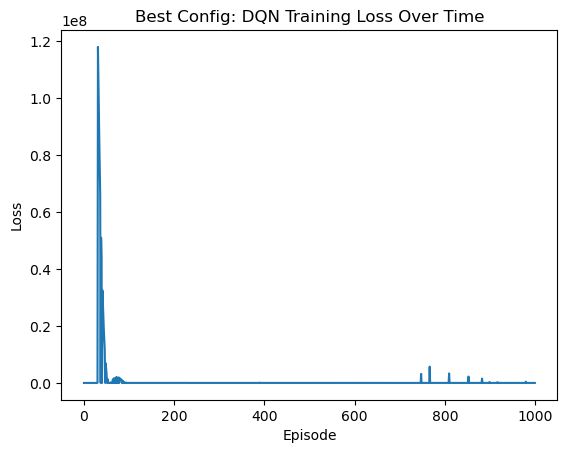

In [17]:
# Part 4.2: 选定最佳参数后，进行完整训练 (用于后续评估)
best_config = {
    'num_episodes': 1000,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 2500,
    'target_update_freq': 10,
    'replay_buffer_size': 10000
}

print("开始使用最佳超参数重新训练DQN模型...")
final_losses, trained_policy_net = train_dqn(best_config)

# 绘制最终训练Loss曲线
plt.plot(final_losses)
plt.title("Best Config: DQN Training Loss Over Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.show()


## Part 6: 模型评估与可视化

Baseline Model MAE: $230,364
Baseline Model RMSE: $718,476
DQN Agent MAE: $237,372
DQN Agent RMSE: $828,527


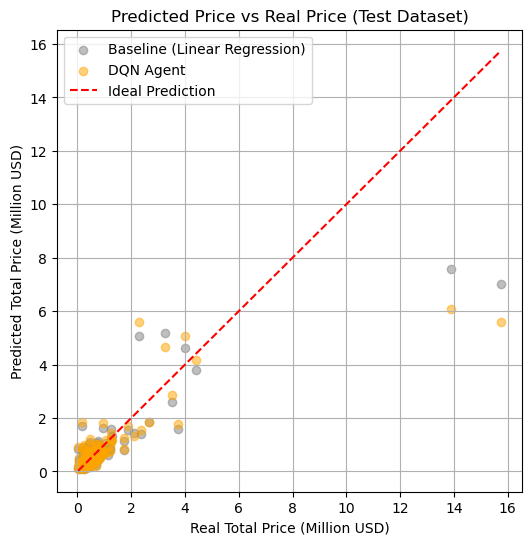

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
trained_policy_net.eval()

# Predict prices for the entire test set
agent_pred_prices = []
for i in range(X_test.shape[0]):
    state = X_test[i]
    base_price = base_price_test[i]
    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        #q_vals = policy_net(state_t)
        q_vals = trained_policy_net(state_t)
    best_action = q_vals.argmax(dim=1).item()
    adjustment = adjustments[best_action]
    pred_price = base_price * (1 + adjustment)
    agent_pred_prices.append(pred_price)

agent_pred_prices = np.array(agent_pred_prices)

# Evaluation Metrics (USD)
agent_mae = mean_absolute_error(y_test_total, agent_pred_prices)
agent_rmse = mean_squared_error(y_test_total, agent_pred_prices, squared=False)

print(f"Baseline Model MAE: ${baseline_mae:,.0f}")
print(f"Baseline Model RMSE: ${baseline_rmse:,.0f}")
print(f"DQN Agent MAE: ${agent_mae:,.0f}")
print(f"DQN Agent RMSE: ${agent_rmse:,.0f}")

# Determine sample size dynamically based on test set size
sample_size = min(1000, len(y_test_total))
sample_idx = np.random.choice(len(y_test_total), size=sample_size, replace=False)

actual_prices_sample = y_test_total[sample_idx]
baseline_prices_sample = base_price_test[sample_idx]
dqn_pred_prices_sample = agent_pred_prices[sample_idx]


# Convert only plotting data to Million USD
actual_prices_sample = y_test_total[sample_idx] / 1_000_000
baseline_prices_sample = base_price_test[sample_idx] / 1_000_000
dqn_pred_prices_sample = agent_pred_prices[sample_idx] / 1_000_000


# Scatter Plot: Predicted vs Real Price (Baseline vs DQN)
plt.figure(figsize=(6,6))
plt.scatter(actual_prices_sample, baseline_prices_sample, color='gray', alpha=0.5, label='Baseline (Linear Regression)')
plt.scatter(actual_prices_sample, dqn_pred_prices_sample, color='orange', alpha=0.5, label='DQN Agent')

# Ideal prediction line (y = x)
min_val = actual_prices_sample.min()
max_val = actual_prices_sample.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

plt.xlabel("Real Total Price (Million USD)")
plt.ylabel("Predicted Total Price (Million USD)")
plt.title("Predicted Price vs Real Price (Test Dataset)")
plt.legend()
plt.grid(True)
plt.show()


## Part 7: 用户输入房产参数估值

最后，我们实现一个接口，允许用户输入房产的特征参数，利用已训练的模型输出该房产的估计价格并解释估值过程。这里我们以字典构造一个示例输入（在实际应用中可以用交互式表单获取用户输入），然后按照与训练数据相同的预处理方式转换特征，经过线性模型和DQN智能体两步得到最终估价。我们将打印每平米单价的线性估计、基础总价以及DQN的调整幅度和最终总价，以帮助用户理解估值过程。

In [ ]:
# Part 6: User Input Valuation (DQN_v4版)

# Example user input (modify as needed)
user_input = {
    'year_built': 1995,
    'beds': 3,
    'baths': 2.5,
    'baths_full': 2,
    'baths_half': 1,
    'garage': 2,
    'lot_sqft': 5000,
    'sqft': 2000,
    'stories': 2
}

# Prepare feature array for prediction
feat_array = np.array([user_input[col] for col in features], dtype=float).reshape(1, -1)

# 1) Linear Regression Estimate (Price per sqft and Base Total Price)
est_price_per_sqft = linreg.predict(feat_array)[0]                     # Price per sqft (USD)
base_total_price = est_price_per_sqft * user_input['sqft']             # Base Total Price (USD)

# 2) DQN Agent Adjustment
state_tensor = torch.FloatTensor(feat_array).to(device)
with torch.no_grad():
    q_vals = policy_net(state_tensor)
best_action_idx = int(torch.argmax(q_vals).item())
adjust_factor = adjustments[best_action_idx]
final_estimated_price = base_total_price * (1 + adjust_factor)         # Final Estimated Price (USD)

# Output Result
print(f"Linear Regression estimated unit price: ${est_price_per_sqft:.2f} per sqft")
print(f"Base estimated total price: ${base_total_price:,.0f}")
if adjust_factor > 0:
    adj_text = f"increase by {adjust_factor*100:.0f}%"
elif adjust_factor < 0:
    adj_text = f"decrease by {-adjust_factor*100:.0f}%"
else:
    adj_text = "no adjustment"
print(f"DQN Agent Recommendation: {adj_text}")
print(f"Final estimated property price: ${final_estimated_price:,.0f}")